In [1]:
%matplotlib inline
import xarray as xr
import xesmf
import os
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import seaborn as sns
import esio
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

os.chdir('/home/disk/sipn/nicway/python/regrid')

gfdl_grid_file = r'GFDLFLOR_gridinfo.nc' # Correct GFDL grid info
gfdl_grid = esio.load_grid_info(gfdl_grid_file, model='GFDL')
ds_in = xr.open_dataset('sic_OImon_GFDL-FLORB01_FLORB01-P1-ECDA-v3.1-122012_r7i1p1_201212-201311.nc')

stero_grid_file = r'stereo_gridinfo.nc'
ds_target = esio.load_grid_info(stero_grid_file, 'NSIDC')
ds_target['lat_b'] = ds_target.lat_b.where(ds_target.lat_b < 90, other = 90)

In [2]:
# Add N+1 coords
ds_in.rename({'lat':'nj', 'lon':'ni'}, inplace=True);
ds_in.coords['nj'] = gfdl_grid.nj
ds_in.coords['ni'] = gfdl_grid.ni
ds_in.coords['lat'] = gfdl_grid.lat
ds_in.coords['lon'] = gfdl_grid.lon
ds_in.coords['lat_b'] = gfdl_grid.lat_b
ds_in.coords['lon_b'] = gfdl_grid.lon_b
ds_in = ds_in.sum(dim='ct').isel(time=0)

In [3]:
ds_in

<xarray.Dataset>
Dimensions:     (bnds: 2, ni: 360, ni_b: 361, nj: 200, nj_b: 201)
Coordinates:
  * bnds        (bnds) float64 1.0 2.0
    time        datetime64[ns] 2012-12-16T12:00:00
  * ni          (ni) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * nj          (nj) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    lat         (nj, ni) float64 -81.5 -81.5 -81.5 -81.5 -81.5 -81.5 -81.5 ...
    lon         (nj, ni) float64 -279.5 -278.5 -277.5 -276.5 -275.5 -274.5 ...
  * nj_b        (nj_b) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * ni_b        (ni_b) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    lat_b       (nj_b, ni_b) float64 -81.0 -81.0 -81.0 -81.0 -81.0 -81.0 ...
    lon_b       (nj_b, ni_b) float64 -280.0 -279.0 -278.0 -277.0 -276.0 ...
Data variables:
    sic         (nj, ni) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    average_DT  timedelta64[ns] ...
    average_T1  datetime64[ns] ...
    average_T

In [4]:
ds_target

<xarray.Dataset>
Dimensions:  (ni: 448, ni_b: 449, nj: 304, nj_b: 305)
Coordinates:
  * nj       (nj) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * ni       (ni) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * nj_b     (nj_b) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * ni_b     (ni_b) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    lat      (nj, ni) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
    lon      (nj, ni) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 ...
    lat_b    (nj_b, ni_b) float64 31.13 31.28 31.42 31.57 31.72 31.86 32.01 ...
    lon_b    (nj_b, ni_b) float64 168.5 168.6 168.7 168.8 168.9 169.0 169.2 ...

In [5]:
# Try different regridding options
regridder1 = xesmf.Regridder(ds_in, ds_target, 'bilinear', periodic=False, reuse_weights=False)
sic_bilinear = regridder1(ds_in.sic)

regridder2 = xesmf.Regridder(ds_in, ds_target, 'conservative', periodic=False, reuse_weights=False)
sic_conservative = regridder2(ds_in.sic)

regridder3 = xesmf.Regridder(ds_in, ds_target, 'nearest_s2d', periodic=False, reuse_weights=False)
sic_nearest_s2d = regridder3(ds_in.sic)

regridder4 = xesmf.Regridder(ds_in, ds_target, 'patch', periodic=False, reuse_weights=False)
sic_patch = regridder4(ds_in.sic)

Create weight file: bilinear_200x360_304x448.nc
Create weight file: conservative_200x360_304x448.nc
Create weight file: nearest_s2d_200x360_304x448.nc
Create weight file: patch_200x360_304x448.nc


# Bilinear

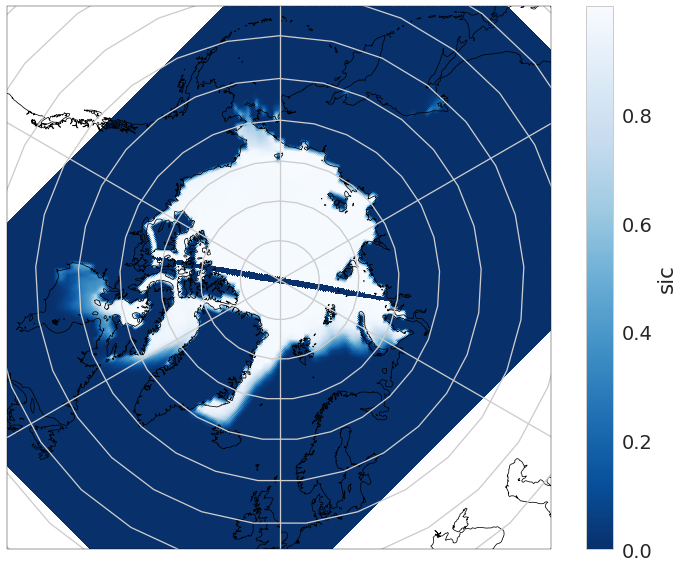

In [6]:
# Plot SIC on target projection
plt.figure(figsize=(10,8));
ax1 = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
sic_bilinear.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(), cmap='Blues_r')
ax1.coastlines(linewidth=0.75, color='black', resolution='50m')
ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax1.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
plt.tight_layout()

# Conservative

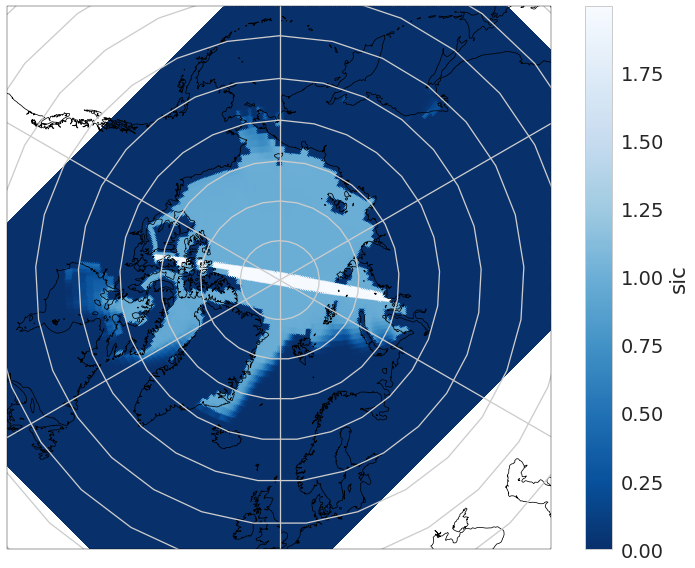

In [7]:
# Plot SIC on target projection
plt.figure(figsize=(10,8));
ax1 = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
sic_conservative.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(), cmap='Blues_r')
ax1.coastlines(linewidth=0.75, color='black', resolution='50m')
ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax1.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
plt.tight_layout()

# Nearest source 2 destination

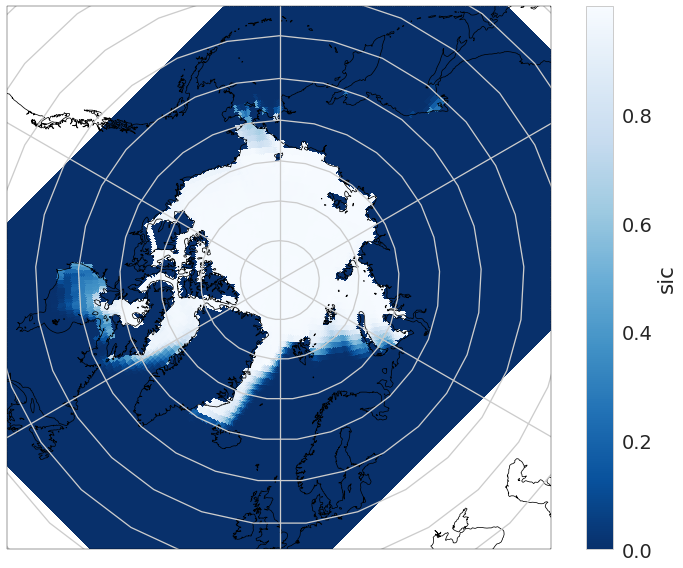

In [8]:
# Plot SIC on target projection
plt.figure(figsize=(10,8));
ax1 = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
sic_nearest_s2d.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(), cmap='Blues_r')
ax1.coastlines(linewidth=0.75, color='black', resolution='50m')
ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax1.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
plt.tight_layout()

# Patch

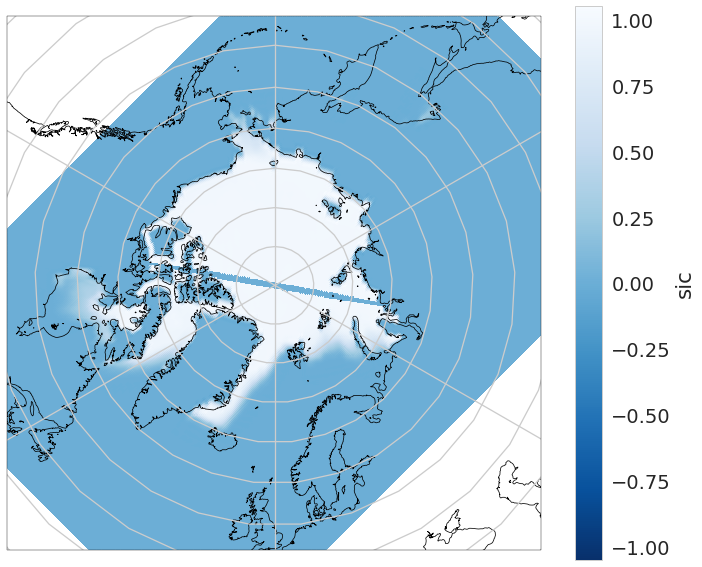

In [9]:
# Plot SIC on target projection
plt.figure(figsize=(10,8));
ax1 = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
sic_patch.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(), cmap='Blues_r')
ax1.coastlines(linewidth=0.75, color='black', resolution='50m')
ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax1.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
plt.tight_layout()